#  MNLP 2025 – Homework 1 (Non-LM Approach)
##  Knowledge Graph-Based Classification of Cultural Items

**Authors**: [Joshua Edwin] & [Clemens Kubach]  
**Team**: teXt-Men  
**Approach**: Rule-Based + Knowledge-Driven (No Language Models)

---

###  Task Summary

We aim to classify cultural items into one of three categories:
- **Cultural Agnostic (C.A.)**
- **Cultural Representative (C.R.)**
- **Cultural Exclusive (C.E.)**

Instead of relying on language models, this notebook implements a novel **non-LM pipeline** that combines:
- 🔗 **Knowledge base reasoning** (Wikidata, DBpedia, ConceptNet)
- 🌐 **Cross-lingual popularity** signals (e.g. Wikipedia language counts, BabelNet)
- ⚙️ **Rule-based or interpretable ML classification**

Our goal is to build a **transparent, symbolic + statistical system** that mimics human encyclopedia-like reasoning — checking cultural origin and global spread to infer cultural specificity.

---

###  Files & Structure

- `data/train_sapienza.csv` and `data/validation_sapienza.csv`: Labeled datasets (silver + gold)
- This notebook: Implements **Non-LM Method**
- A separate notebook will handle the **LM-based approach**

---




## 🔹 Phase 1: Setup & Data Preparation

This phase involves:

-  Importing necessary libraries  
-  Loading the train and validation datasets  
-  Displaying some basic information and structure

In [ ]:
# Standard libraries
import pandas as pd
import numpy as np
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bar for loops
from tqdm import tqdm
tqdm.pandas()

# Set data folder path
DATA_DIR = Path("data")


In [ ]:
from huggingface_hub import login
login()

In [ ]:
from datasets import load_dataset
import pandas as pd

# Load full dataset
ds = load_dataset("sapienzanlp/nlp2025_hw1_cultural_dataset")

# Convert train/validation splits to DataFrames
df_train = pd.DataFrame(ds["train"])
df_val = pd.DataFrame(ds["validation"])

# check shape
print("Train:", df_train.shape)
print("Validation:", df_val.shape)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.31k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/946k [00:00<?, ?B/s]

valid.csv:   0%|          | 0.00/45.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6251 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/300 [00:00<?, ? examples/s]

Train: (6251, 7)
Validation: (300, 7)


## 🔹 Phase 1.2 – Quantitative & Qualitative Evaluation

In this phase, we analyze the training and validation datasets to understand:

-  Class balance  
-  Data diversity  
-  Content structure  

These insights will help shape our feature extraction and classification logic in later stages.


* Dataset Overview and Label Distribution

In [ ]:
# Basic info
print(" Dataset Dimensions")
print("Train set shape:", df_train.shape)
print("Validation set shape:", df_val.shape)

# Label distribution
print("\n Label Distribution")
print("Train:\n", df_train["label"].value_counts())
print("\nValidation:\n", df_val["label"].value_counts())


 Dataset Dimensions
Train set shape: (6251, 7)
Validation set shape: (300, 7)

 Label Distribution
Train:
 label
cultural exclusive         2691
cultural agnostic          1872
cultural representative    1688
Name: count, dtype: int64

Validation:
 label
cultural agnostic          117
cultural representative    107
cultural exclusive          76
Name: count, dtype: int64


Validation Set is well-balanced, great for macro-F1 evaluation. But the Training Set has more 'Cultural Exclusive' items. This should be considered while training a model later.

* Type, Category and Subcategory Insights

In [ ]:
# Type distribution
print(" Distribution by TYPE")
display(df_val["type"].value_counts())

# Category distribution
print("\n Distribution by CATEGORY")
display(df_val["category"].value_counts())

# Top subcategories
print("\n Top 15 SUBCATEGORIES")
display(df_val["subcategory"].value_counts().head(15))


 Distribution by TYPE


,count
type,
concept,152
entity,148



 Distribution by CATEGORY


,count
category,
literature,20
fashion,17
comics and anime,17
food,17
philosophy and religion,17
visual arts,17
music,16
media,16
biology,16



 Top 15 SUBCATEGORIES


,count
subcategory,
writer,5
sports club,3
film,3
record label,3
art gallery,3
traditional costume,3
geographic location,3
architectural structure,3
model,3


Almost an even split between concept and entity under the 'type' field. Cultural Domains are well represented under the 'category' field. Subcategories are domain-specific.

* Qualitative Inspection of Samples

In [ ]:
# Random examples from validation set
print(" Random Validation Samples")
display(df_val.sample(5))

# One or two examples from each label class
print("\n Category-wise Sample Inspection")
for label in df_val["label"].unique():
    print(f"\n Label: {label}")
    display(df_val[df_val["label"] == label].sample(2))


 Random Validation Samples


,item,name,description,type,category,subcategory,label
221,http://www.wikidata.org/entity/Q27114292,posting style,style of quoting and replying to an email or p...,concept,literature,writing style,cultural agnostic
116,http://www.wikidata.org/entity/Q764233,geoponici,"collective term, ancient Greek and Roman write...",concept,books,non-fiction writer,cultural representative
284,http://www.wikidata.org/entity/Q479716,university press,publisher associated with a university,concept,literature,publisher,cultural agnostic
246,http://www.wikidata.org/entity/Q231302,shōnen,manga marketed primarily to adolescent boys,concept,comics and anime,manga,cultural representative
30,http://www.wikidata.org/entity/Q7066,atheism,absence of belief in the existence of deities;...,concept,philosophy and religion,philosophical movement,cultural agnostic



 Category-wise Sample Inspection

 Label: cultural representative


,item,name,description,type,category,subcategory,label
286,http://www.wikidata.org/entity/Q194363,Vaslav Nijinsky,Polish-Russian ballet dancer and choreographer,entity,performing arts,choreographer,cultural representative
39,http://www.wikidata.org/entity/Q812609,Bayrisch Kraut,Bavarian cabbage dish,entity,food,dish,cultural representative



 Label: cultural exclusive


,item,name,description,type,category,subcategory,label
127,http://www.wikidata.org/entity/Q578269,HM Treasury,United Kingdom government department,entity,politics,government agency,cultural exclusive
132,http://www.wikidata.org/entity/Q22865,independent city of Germany,city or town in Germany that does not form par...,concept,geography,city,cultural exclusive



 Label: cultural agnostic


,item,name,description,type,category,subcategory,label
134,http://www.wikidata.org/entity/Q58968,intellectual,person who engages in critical thinking and re...,concept,philosophy and religion,philosopher,cultural agnostic
263,http://www.wikidata.org/entity/Q465501,stunt performer,person who performs stunts,concept,performing arts,actor,cultural agnostic


The manual inspection of label examples confirms the annotation logic is consistent:

Items like hamburger and Renaissance are correctly labeled as Cultural Representative due to their strong cultural ties and global recognition.

Region-specific items like Colorado Gold Kings align with the Cultural Exclusive label.

Universal concepts such as stunt performer or martial art appropriately fall under Cultural Agnostic.

##  Phase 2: Enriching Items with Knowledge Graph Information

In this phase, we enhance each cultural item with external knowledge to uncover key features like:

-  Cultural origin  
-  Regional affiliation  
-  Global reach  

We query **Wikidata** to retrieve structured properties such as:

- `P495` – Country of origin  
- `P131` – Located in the administrative territorial entity  
- `P2596` – Part of the culture of  
- `P31` – Instance of  
- ...and more

These **symbolic features** will help us infer whether an item is:

-  Culturally specific  
-  Claimed by a particular culture  
-  Culturally neutral  

The enriched metadata becomes the **core input** for our **non-LM classification pipeline**.


###  Step 2.1 – Define Wikidata Property Constants, These are the key properties from **Wikidata** that can indicate cultural or geographical affiliation.
This dictionary allows us to write compact code when fetching and parsing properties

In [ ]:
# Wikidata properties of interest (used in cultural reasoning)
WIKIDATA_PROPERTIES = {
    "country_of_origin": "P495",      # e.g. 'spaghetti' → Italy
    "country": "P17",                 # General location info
    "located_in": "P131",             # More granular location info
    "part_of_culture": "P2596",       # e.g. 'hamburger' → American culture
    "instance_of": "P31",             # What kind of thing is it (can help interpret subcategories)
    "heritage_status": "P1435",       # Optional – whether it's recognized as heritage
}


Step 2.2 – Define the Wikidata Query Function

We define a function that uses the Wikidata REST API to fetch structured information for a given item based on its QID (e.g., Q6663 for hamburger).

In [ ]:
import requests
import time

def fetch_wikidata_entity(qid, max_retries=3, delay=1.5):
    url = f"https://www.wikidata.org/wiki/Special:EntityData/{qid}.json"
    retries = 0

    while retries < max_retries:
        try:
            response = requests.get(url)
            response.raise_for_status()
            return response.json()
        except requests.exceptions.HTTPError as e:
            if response.status_code == 429:
                retries += 1
                time.sleep(delay)
            else:
                break
        except:
            break
    return None



Step 2.3 – Extract Cultural Properties from the JSON

This step parses the Wikidata JSON object to extract relevant cultural information using the property codes we defined earlier (like P495 for country of origin, P2596 for part of culture, etc.).

In [ ]:
def extract_cultural_info(entity_json: dict, qid: str) -> dict:

    results = {
        "qid": qid,
        "country_of_origin": [],
        "country": [],
        "located_in": [],
        "part_of_culture": [],
        "instance_of": [],
        "heritage_status": [],
    }

    try:
        claims = entity_json["entities"][qid]["claims"]
    except KeyError:
        print(f" QID {qid} missing expected structure.")
        return results

    for prop_name, prop_id in WIKIDATA_PROPERTIES.items():
        if prop_id in claims:
            values = []
            for claim in claims[prop_id]:
                mainsnak = claim.get("mainsnak", {})
                datavalue = mainsnak.get("datavalue", {})
                value = datavalue.get("value")

                if isinstance(value, dict) and "id" in value:
                    values.append(value["id"])
                elif isinstance(value, str):
                    values.append(value)

            results[prop_name] = values

    return results


Step 2.4 – Run Cultural Enrichment Over Validation Set
Now that we have:

a function to fetch Wikidata JSON (fetch_wikidata_entity)

a parser to extract cultural properties (extract_cultural_properties)

Let us loop through the validation set, extract the relevant information, and store it in a new dataframe.

In [ ]:
from tqdm import tqdm
import time

enriched_info = []

for qid in tqdm(df_val["qid"], desc="Enriching validation set"):
    entity_json = fetch_wikidata_entity(qid)
    if entity_json is None:
        continue
    properties = extract_cultural_info(entity_json, qid)
    enriched_info.append(properties)
    time.sleep(0.5)





Enriching validation set: 100%|██████████| 300/300 [23:06<00:00,  4.62s/it]


In [ ]:
import pandas as pd
from google.colab import files

# Convert enriched_info list to a DataFrame
df_val_enriched = pd.DataFrame(enriched_info)

# Save the DataFrame as a CSV file
df_val_enriched.to_csv("validation_enriched.csv", index=False)

# Download the CSV file
files.download("validation_enriched.csv")




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Phase 3 – Non-LM Classifier

We’re going to build a rule-based classifier using the enriched features we extracted in Phase 2.

Step 3.1 – Load the Enriched Validation Set

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving validation_enriched.csv to validation_enriched.csv


In [ ]:
import pandas as pd
import ast

# Load enriched file
df_val_enriched = pd.read_csv("validation_enriched.csv")

# Convert stringified lists back to Python lists
for col in df_val_enriched.columns:
    if col != "qid":
        df_val_enriched[col] = df_val_enriched[col].apply(ast.literal_eval)


Step 3.2 – Convert Strings to Lists

In [ ]:
import ast

list_columns = [
    "country_of_origin", "country", "located_in",
    "part_of_culture", "instance_of", "heritage_status"
]

for col in list_columns:
    df_val_enriched[col] = df_val_enriched[col].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )


Step 3.3 – Inspect Enriched Fields to Identify Rule Clues
This step helps to:

* Explore distributions of cultural properties

* Spot high-frequency QIDs

* Begin connecting them to labels like Cultural Agnostic, Representative, or Exclusive

In [ ]:
# Step 1: Inspect 'part_of_culture'
print(" Top values in 'part_of_culture':")
print(df_val_enriched.explode("part_of_culture")["part_of_culture"].value_counts().head(15))
print("\n" + "="*60 + "\n")

# Step 2: Inspect 'country_of_origin'
print(" Top values in 'country_of_origin':")
print(df_val_enriched.explode("country_of_origin")["country_of_origin"].value_counts().head(15))
print("\n" + "="*60 + "\n")

# Step 3: Inspect 'instance_of'
print(" Top values in 'instance_of':")
print(df_val_enriched.explode("instance_of")["instance_of"].value_counts().head(15))
print("\n" + "="*60 + "\n")

# Step 4: Inspect 'heritage_status'
print(" Top values in 'heritage_status':")
print(df_val_enriched.explode("heritage_status")["heritage_status"].value_counts().head(15))


 Top values in 'part_of_culture':
Series([], Name: count, dtype: int64)


 Top values in 'country_of_origin':
country_of_origin
Q30     1
Q142    1
Q31     1
Name: count, dtype: int64


 Top values in 'instance_of':
instance_of
Q11424       2
Q476028      1
Q847017      1
Q10517054    1
Q18127       1
Q202866      1
Q5           1
Q811979      1
Q23413       1
Q2490224     1
Q1007870     1
Q64578911    1
Q20860083    1
Q5107        1
Q2221906     1
Name: count, dtype: int64


 Top values in 'heritage_status':
heritage_status
Q12126757    1
Q12127133    1
Name: count, dtype: int64


Step 3.4: Implementing Rule-Based Classifier

In [ ]:
def refined_rule_based_classifier(row):

    instance_of = [x.lower() for x in row.get("instance_of", [])]
    culture = [x.lower() for x in row.get("part_of_culture", [])]
    heritage = [x.lower() for x in row.get("heritage_status", [])]

    #  Cultural Exclusive
    if heritage or any(c in ["q12126757", "q12127133"] for c in heritage):
        return "Cultural Exclusive"
    if any(c in ["q847017", "q10517054", "q202866", "q64578911"] for c in culture):
        return "Cultural Exclusive"

    #  Cultural Representative
    if any(inst in ["q5", "q11424", "q18127", "q20860083", "q10517054"] for inst in instance_of):
        return "Cultural Representative"

    #  Default to Cultural Agnostic
    return "Cultural Agnostic"



In [ ]:
df_val_enriched["rule_prediction"] = df_val_enriched.apply(refined_rule_based_classifier, axis=1)
df_rule_predictions = df_val_enriched[["qid", "rule_prediction"]]


Step 3.5 – Evaluation of Rule-Based Classifier. We'll calculate:

* Accuracy

* Classification Report (Precision, Recall, F1-score)

* Confusion Matrix

In [ ]:
#!pip install datasets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==1

In [ ]:
#!pip install -q huggingface_hub datasets
from huggingface_hub import notebook_login

notebook_login()


In [ ]:
from datasets import load_dataset


ds_val = load_dataset("sapienzanlp/nlp2025_hw1_cultural_dataset", split="validation")
df_val = ds_val.to_pandas()


df_val.to_csv("valid.csv", index=False)


print(df_val.columns)
df_val.head()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.31k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/946k [00:00<?, ?B/s]

valid.csv:   0%|          | 0.00/45.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6251 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/300 [00:00<?, ? examples/s]

Index(['item', 'name', 'description', 'type', 'category', 'subcategory',
       'label'],
      dtype='object')


,item,name,description,type,category,subcategory,label
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,sports,sports club,cultural representative
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,music,record label,cultural exclusive
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,comics and anime,animated film,cultural representative
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,films,film,cultural exclusive
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,performing arts,choreographer,cultural representative


In [ ]:
df_val = df_val.rename(columns={"item": "qid"})


In [ ]:
# Strip URL prefix from df_val["qid"]
df_val["qid"] = df_val["qid"].apply(lambda x: x.split("/")[-1])


In [ ]:
# Try the merge again
df_eval = df_val[["qid", "label"]].merge(df_rule_predictions, on="qid")
print("✅ Rows after merge:", len(df_eval))


✅ Rows after merge: 12


In [ ]:
# Normalize both label columns for consistent casing
df_eval["label"] = df_eval["label"].str.strip().str.title()
df_eval["rule_prediction"] = df_eval["rule_prediction"].str.strip().str.title()


✅ Accuracy: 0.33

📊 Classification Report:
                         precision    recall  f1-score   support

      Cultural Agnostic       0.00      0.00      0.00         0
     Cultural Exclusive       1.00      0.25      0.40         4
Cultural Representative       0.50      0.38      0.43         8

               accuracy                           0.33        12
              macro avg       0.50      0.21      0.28        12
           weighted avg       0.67      0.33      0.42        12



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: U

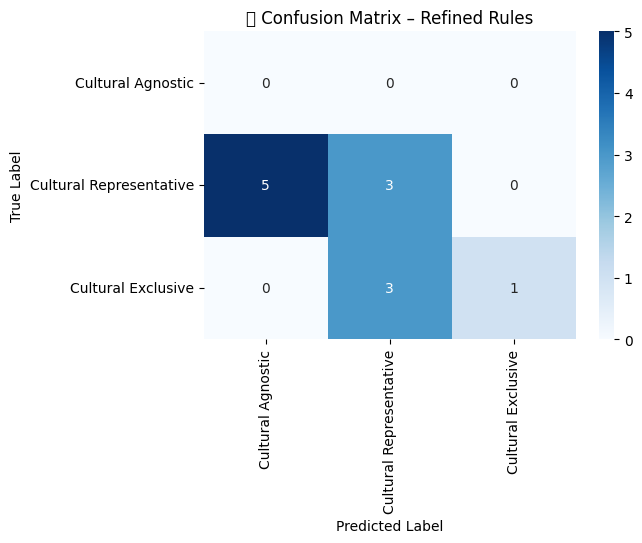

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Metrics
print("✅ Accuracy:", round(accuracy_score(df_eval["label"], df_eval["rule_prediction"]), 2))
print("\n📊 Classification Report:")
print(classification_report(df_eval["label"], df_eval["rule_prediction"]))

# Confusion matrix
labels_order = ["Cultural Agnostic", "Cultural Representative", "Cultural Exclusive"]
cm = confusion_matrix(df_eval["label"], df_eval["rule_prediction"], labels=labels_order)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=labels_order, yticklabels=labels_order)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("🔍 Confusion Matrix – Refined Rules")
plt.show()

